# Part X: IGS SCD Analysis


Concerning SCD detection and size + lamin analysis.

# 0. Intializations

In [ ]:
import random, os, sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join(r"..", r".")))

from source import const
from source import matrixtools as mt
from source import scdtools as scd

from matplotlib.patches import Rectangle 
from scipy.spatial import distance
from scipy.stats import ks_2samp
from scipy.stats import iqr

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}

mpl.rcParams.update(new_rc_params)

%matplotlib notebook

In [ ]:
datapath = "../datasets/Table_S2_embryo_data_table.csv"
embryo_data = pd.read_csv(datapath,index_col=False)

# Filter extrachromosomal reads
embryo_data = embryo_data.loc[embryo_data["inlier"]!=0]

parent = 2 # 1 = maternal, 2 = paternal

num_chrs = len(const.SIZES_MM10[1:-1]) # since 1-indexed and unmappable ChrY in mouse

#retrieve paternal zygotes
zygotes = embryo_data.loc[embryo_data["stage"] == "zygote"]
zygotes = zygotes.loc[zygotes["cluster"] == parent]
zygotes = zygotes.loc[zygotes["chr"] < num_chrs + 1]

# 1. Filter and process high coverage chromosomes

In [ ]:
cell_indexes = zygotes["cell_index"].unique()
resolution = 2.5*10**6

cells = []

for ci in cell_indexes:
    cell = zygotes.loc[zygotes["cell_index"] == ci]
    cells.append(cell)

In [ ]:
matrices, clusters = mt.filter_chromosomes(zygotes, resolution = 2.5*10**6, coverage_threshold=0.1,statistic='mean')

#todo state number of chromosomes passing filter
#todo suppress error message

# 2. Call and visualize sample SCDs

In [ ]:
def plot_distance_matrix(M, cluster, resolution, clim=(3,24), scale=2, label = '\nSpatial Distance [um]'):
    
    chr_num = cluster["chr"].unique()[0]
    
    fig, axs = plt.subplots(nrows=2, ncols=1)
    
    mat_ax, domain_ax = 0, 1
    
    res = resolution / 10**6
    extent = [0, res*len(M), res*len(M),0]
    cmap = plt.get_cmap('seismic_r')

    cmap.set_bad(color='grey')
    
    cax = axs[mat_ax].imshow(M,interpolation='nearest',cmap=cmap, extent=extent, norm=mpl.colors.LogNorm()) 
    cbar = fig.colorbar(cax, ax=axs[mat_ax], label=label, ticks = [3,6,10,12,24])
    axs[mat_ax].set_xticks([0,np.ceil(res*len(M))])
    axs[mat_ax].set_yticks([np.ceil(res*len(M)),0])
    
    cax.set_clim(clim)
    axs[mat_ax].set_xlabel("\n Chr 11 Genomic Coordinate [Mb]")
    axs[mat_ax].set_ylabel("\n Chr 11 Genomic Coordinate [Mb]")
    
    peaks,dists = scd.get_peaks(M)
    peaks = scd.handle_edges(peaks,M)*res
    
    for i in range(1, len(peaks)):
        
        left, right = peaks[i-1], peaks[i]
    
        rect = Rectangle(
            xy=(left, 0.8),
            width = right - left - 1,
            height = 0.05,
            facecolor = const.DISTINCT_COLORS[i],
            edgecolor = 'black',
            linewidth = 0.5
        )
        axs[domain_ax].add_patch(rect) 
    
    axs[domain_ax].set_xlim(0,len(M)*res)
    for loc in ['top','bottom','left','right']:
        axs[domain_ax].spines[loc].set_visible(False)

    axs[domain_ax].tick_params(axis='x', which='both',bottom=False,labelbottom=False)
    axs[domain_ax].tick_params(axis='y', which='both',left=False,labelleft=False)
    
    cbar2 = fig.colorbar(cax, ax=axs[domain_ax],label='\nSpatial Distance [um]', ticks = [3,6,12,24])

    asp = np.diff(axs[domain_ax].get_xlim())[0] / np.diff(axs[domain_ax].get_ylim())[0]
    axs[domain_ax].set_aspect(asp)

    plt.tight_layout()
    cbar2.remove()

    fig.set_size_inches(8,8)
    plt.show()    

    return (fig, axs)

embryo_7_chr11 = 32


<IPython.core.display.Javascript object>


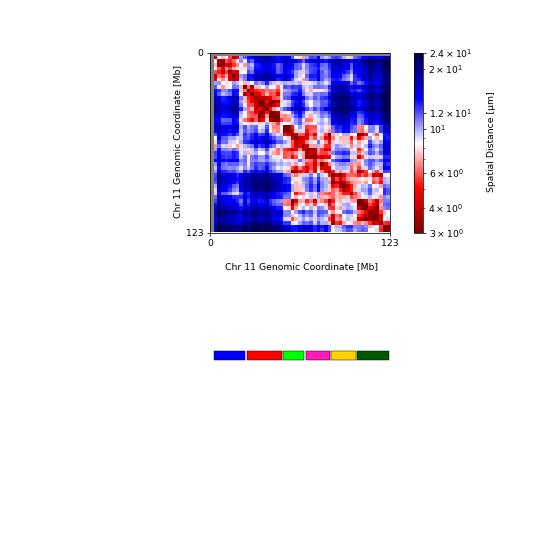

/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


In [6]:
idx = 32 #embryo 7, chromosome 11 

M, C = matrices[idx], clusters[idx]

(fig, ax) = plot_distance_matrix(M, C,label ='\n Spatial Distance [μm]', resolution=2.5*10**6,clim=(3,24))

plt.savefig("./panel_e_single_cells/embryo7_chr11pat.svg")

<IPython.core.display.Javascript object>


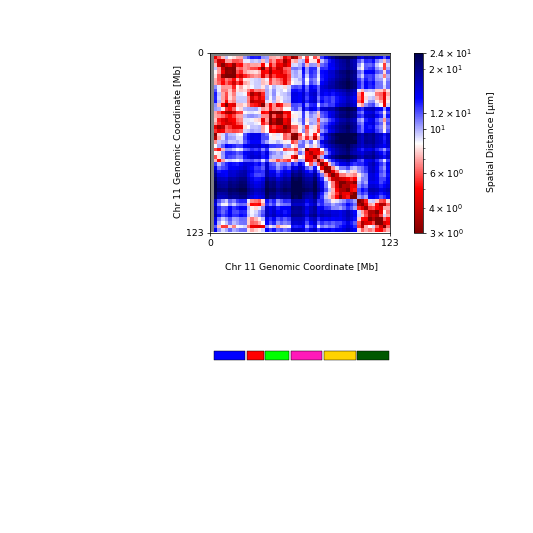

In [7]:
idx = 46 #embryo 7, chromosome 11 
M, C = matrices[idx], clusters[idx]
(fig, ax) = plot_distance_matrix(M, C,label ='\n Spatial Distance [μm]', resolution=2.5*10**6, clim=(3,24))

plt.savefig("./panel_e_single_cells/embryo8_chr11pat.svg")

# 3. Call all SCDs and analyze sizes

In [8]:
sizes = []
#List of peaks for each chromosome
peaks_vector = []
for i in range(len(matrices)):
    peaks, dists = scd.get_peaks(matrices[i])
    peaks_vector.append(peaks)
    peaks = scd.handle_edges(peaks, matrices[i])
    for j in range(1, len(peaks)):
        size = peaks[j] - peaks[j-1]
        sizes.append(size)
sizes = np.array(sizes)

print(str(len(sizes)) + " SCDs detected")

1286 SCDs detected


<IPython.core.display.Javascript object>


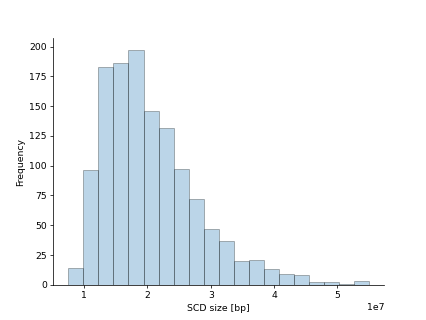

Median SCD size = 17500000.0
IQR = 10000000.0


In [9]:
fig, ax = plt.subplots()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.hist(sizes*resolution,bins=20,alpha=0.3,histtype='bar',ec='black')

ax.set_xlabel("SCD size [bp]")
ax.set_ylabel("Frequency")

print("Median SCD size = " + str(np.median(sizes)*resolution))
print("IQR = " + str(iqr(sizes*resolution)))

plt.savefig("./s25_sizes/scd_sizes.svg")

# 4. Generate SCDs mapping plot (all cells/chrs)

In [10]:
def generate_sc_SCD_mapping(matrices, clusters, resolution = 2*10**6, coverage_threshold=0.1,
                            statistic='median'):
    
    for i in range(1, 21):
        Ms = []
        Cs = []
        for j in range(len(clusters)):
            if clusters[j]["chr"].unique()[0] == i:
                Ms.append(matrices[j])
                Cs.append(clusters[j])
                
        fig, axs = plt.subplots(len(Ms),1)
        
        for j in range(len(Ms)):
            peaks, dists = scd.get_peaks(Ms[j], ws=5, make_plots=False)
            peaks = scd.handle_edges(peaks, Ms[j])
            peaks = peaks*2.5
            for k in range(1,len(peaks)):
                left_bd = peaks[k-1]
                right_bd = peaks[k]
                rect = Rectangle(
                    xy=(left_bd, 0.1),
                    width = (right_bd - left_bd),
                    height = 0.5,
                    facecolor =  const.DISTINCT_COLORS[k+1],
                    edgecolor ='black',
                    linewidth = 1
                )
                

                axs[j].add_patch(rect) 
                axs[j].set_xlim(-1,len(Ms[j])*2.5)
                axs[j].tick_params(axis='y', which='both',left=False,labelleft=False)
                if j == 0: 
                    l = axs[j].set_ylabel("")
                else:
                    l = axs[j].set_ylabel("\n"+str(j+1)+"   ")
                    l.set_rotation(0)
                if j != len(Ms)-1: axs[j].set_xticks([])
                    
        
        #axs[j].set_xlabel("Genomic Position [Mb]")
        title = "Chr " + str(i) 
        axs[0].set_title(title)
        path = "./s25_sizes/heatmap_chr"+str(i) + ".svg"
        plt.savefig(path, transparent = True, bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


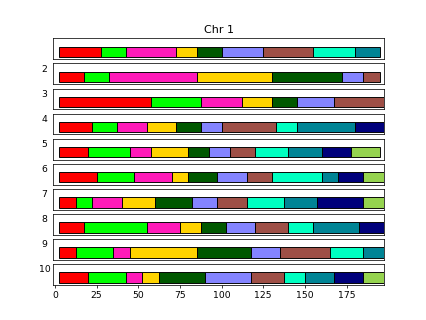

<IPython.core.display.Javascript object>


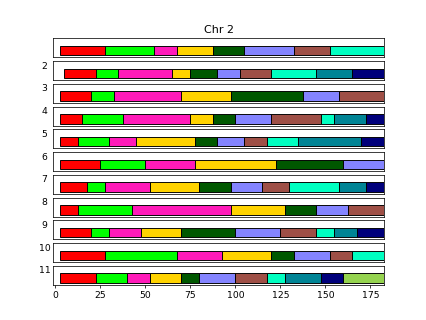

<IPython.core.display.Javascript object>


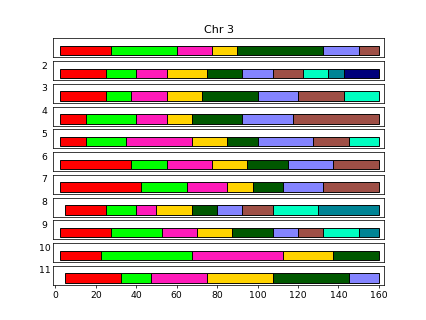

<IPython.core.display.Javascript object>


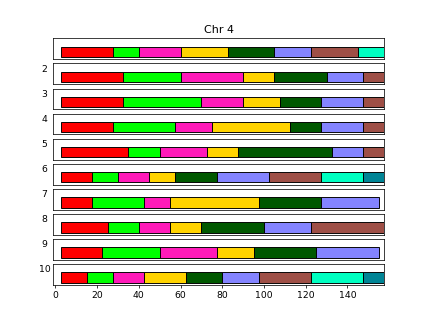

<IPython.core.display.Javascript object>


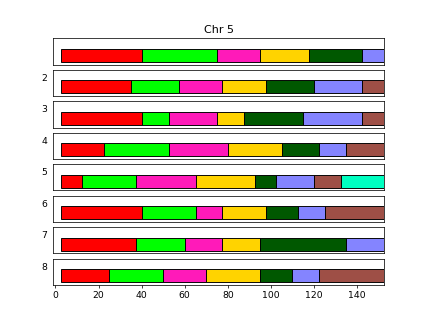

<IPython.core.display.Javascript object>


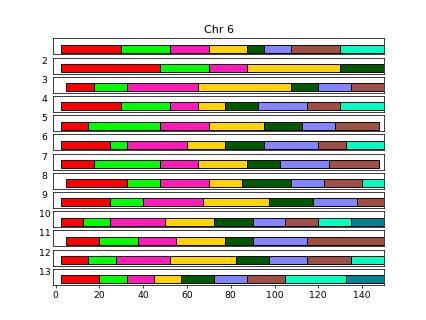

<IPython.core.display.Javascript object>


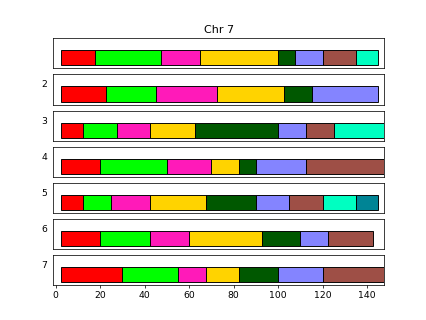

<IPython.core.display.Javascript object>


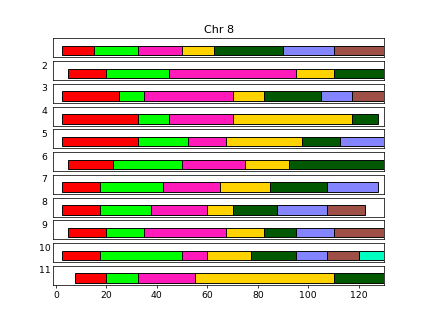

<IPython.core.display.Javascript object>


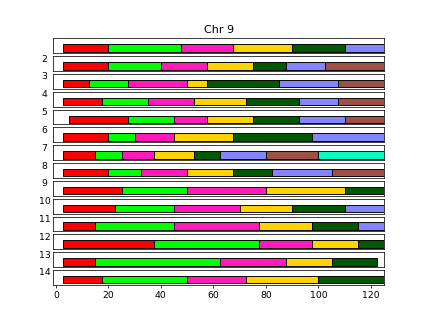

<IPython.core.display.Javascript object>


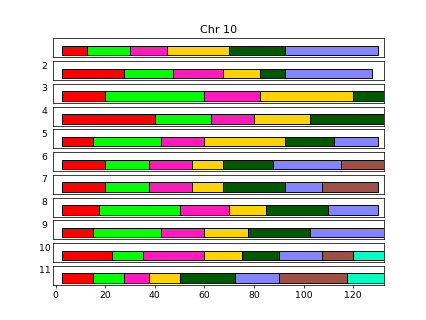

<IPython.core.display.Javascript object>


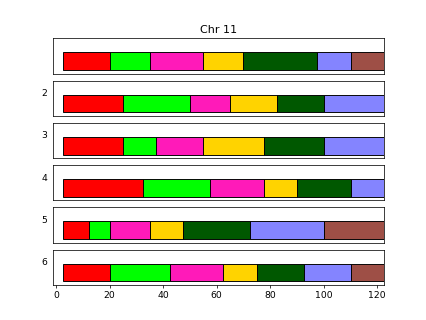

<IPython.core.display.Javascript object>


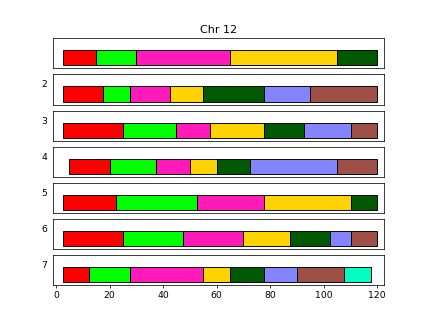

<IPython.core.display.Javascript object>


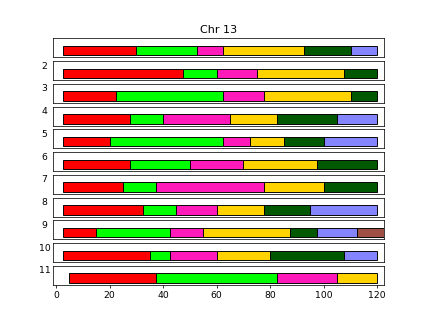

<IPython.core.display.Javascript object>


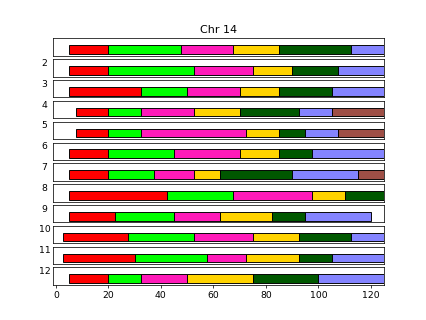

<IPython.core.display.Javascript object>


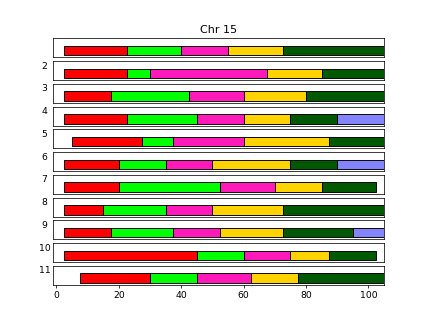

<IPython.core.display.Javascript object>


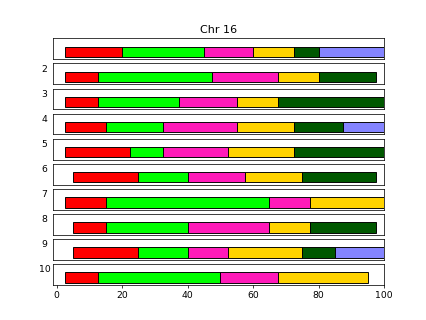

<IPython.core.display.Javascript object>


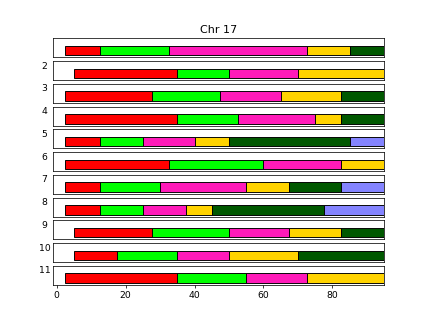

/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


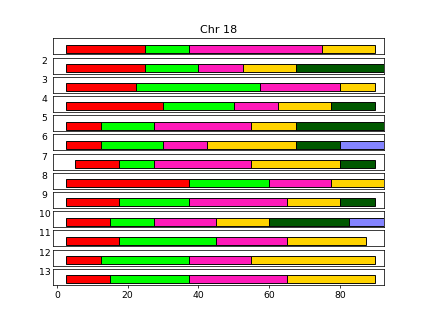

<IPython.core.display.Javascript object>


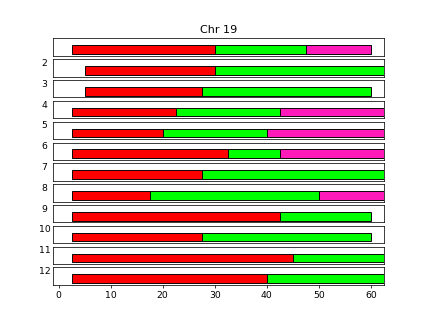

<IPython.core.display.Javascript object>


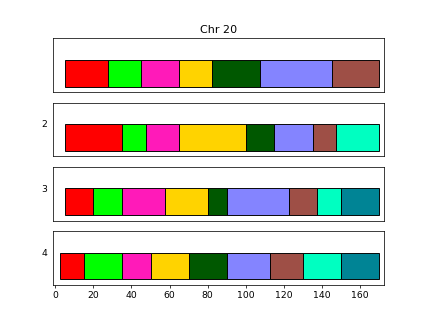

In [11]:
generate_sc_SCD_mapping(matrices, clusters, resolution = 2.5*10**6, coverage_threshold=0.1,
                            statistic='median')

# 5. Compare SCD and Ensemble boundaries

In [12]:
def build_ensemble_matrix(data, chr_num):
    
    _data = data.loc[data["chr"] == chr_num]
        
    cell_indexes = _data["cell_index"].unique()

    cells, matrices, clusters = [], [], []

    for ci in cell_indexes:
        cell = _data.loc[data["cell_index"] == ci]
        cells.append(cell)

    chr_size = const.SIZES_MM10[chr_num]
    num_bins = int(np.ceil(chr_size/resolution))
    M = mt.build_empty_matrix(num_bins)
    B = np.arange(0, num_bins+1) #bin vector
    count=0
    for cluster in cells:
        #Get coordinate vector and genomic position vector
        X = np.array([cluster['x_um_abs'].values, cluster['y_um_abs'].values, cluster['z_um_abs'].values]).T
        P = np.array(cluster['pos'].values)

        #Bin position vector and then populate binned matrix from unbinned matrix of pdists using binned indices
        P_inds = np.digitize(P, B*resolution) - 1    
        X_pdist = distance.pdist(X)
        X_sf = distance.squareform(X_pdist)
        count+=len(P_inds)
        for i in range(len(P_inds)):
            for j in range(i+1, len(P_inds)):
                if X_sf[i][j] == 0: continue #ignore self
                ii, jj = P_inds[i], P_inds[j]
                M[ii][jj].append((X_sf[i][j]))
                M[jj][ii].append((X_sf[i][j]))
   
    M = mt.flatten_matrix(M, statistic='mean')
    return(M)

In [13]:
E = build_ensemble_matrix(zygotes, 11)

/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


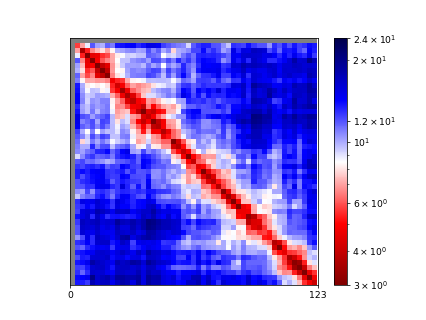

In [14]:
def plot_ensemble_matrix(M, resolution, clim=(3,24)):
    fig, ax = plt.subplots()

    res = resolution / 10**6
    extent = [0, res*len(M), res*len(M),0]
    cmap = plt.get_cmap('seismic_r')
    cmap.set_bad(color='grey')

    cax = ax.imshow(M,interpolation='nearest',cmap=cmap, extent=extent, norm=mpl.colors.LogNorm()) 
    cbar = fig.colorbar(cax, ticks = [3,6,10,12,24])
    ax.set_xticks([0,np.ceil(res*len(M))])
    
    ax.set_yticks([])
    
    cax.set_clim(clim)
    
    return fig, ax

fig, ax = plot_ensemble_matrix(E, resolution)
plt.savefig("./panel_c_ensemble/scd_sizes.svg")

In [15]:
sc_strengths = []
ensemble_strengths = []

for i in range(1,21):
    E = build_ensemble_matrix(zygotes, i)
    peaks, dists = scd.get_peaks(E)
    dists = dists*-1 #invert to express strength as a maxima
    peaks = scd.handle_edges(peaks,E)
    ensemble_strengths.extend(dists[peaks[1:-1]])
    
for m in matrices:
    peaks, dists = scd.get_peaks(m)
    dists = dists*-1 #invert to express strength as a maxima
    peaks = scd.handle_edges(peaks, m)
    sc_strengths.extend(dists[peaks[1:-1]])
    


In [16]:
## calculate effect size by Cohen's d
def cohens_d(d1,d2):
    mean1 = np.mean(d1)
    mean2 = np.mean(d2)
    var1 = np.var(d1,ddof=1)
    var2 = np.var(d2,ddof=1)
    n1 = len(d1)
    n2 = len(d2)
    
    s_pooled = np.sqrt((var1*(n1-1)+var2*(n2-1))/(n1+n2-2))
    
    d = (mean1-mean2)/s_pooled
    
    return d

#make 2-sample bootstrap based on the above
def bootstrap_2samp(data1,data2,n=5000,func=cohens_d):
    #generate n pairs of bootstrap samples fram the pair of datasets, evaluating func at each resampling.
    #bootstrap_2samp returns a funnction that can be called to obtain confidence intervals.
    
    simulations = list()
    sample_size1 = len(data1)
    sample_size2 = len(data2)
    
    for i in range(n):
        resample1 = np.random.choice(data1,size=sample_size1,replace=True)
        resample2 = np.random.choice(data2,size=sample_size2,replace=True)
        simulations.append(func(resample1,resample2))
    simulations.sort()
    
    def ci(p):
        #Return 2-sided symmetric confidence interval specified by p
        
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

boot_cohens_d = bootstrap_2samp(sc_strengths,ensemble_strengths,n=5000,func=cohens_d)
d_interval = boot_cohens_d(0.95)
d_interval

(0.5680427457564023, 0.7645847663455283)

In [17]:
p = ks_2samp(sc_strengths, ensemble_strengths)[1]
print("p = "+str(p))

print("N single cell boundaries = "+str(len(sc_strengths)))
print("N ensemble_boundaries = " + str(len(ensemble_strengths)))

p = 2.220446049250313e-16
N single cell boundaries = 1083
N ensemble_boundaries = 75


/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


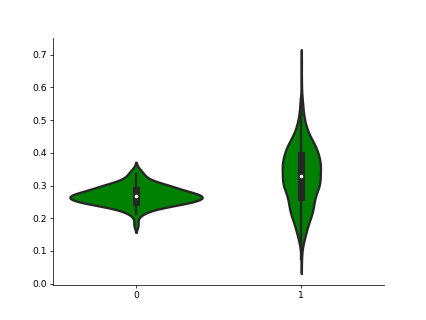

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

color = ["green","green"]

data = [np.array(ensemble_strengths),np.array(sc_strengths)]
flierprops = dict(marker='o')

ax = sns.violinplot(data=data,orient='v', palette=color, linewidth=2.5,bootstrap=1000,notch=False,saturation=1,
                 flierprops=flierprops,showfliers=False,showextrema=False)

plt.savefig("./panel_e_single_cells/boundary_strengths.svg")

# 6. Measure lamin association with SCDs

In [19]:
def make_oe_lamin_plot(oe, estimator = np.median):
    
    fig, ax = plt.subplots()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(0,0.5)

    ax.hlines(1,0,1, linestyle="--")

    ax = sns.lineplot(x='pos',y='val',data=oe, estimator = estimator)

    ax.set_xlabel("Scaled Distance from Domain Boundary")
    ax.set_ylabel("Median Distance to Lamin [observed/expected]")
    
    return fig, ax

In [20]:
scd_scaled_dists, shifted_scaled_dists = scd.get_scd_scaled_lamin_vectors(matrices,clusters,num_scaled_bins=22,
                                                                         resolution = 2.5*10**6)

cluster0 of 203
cluster1 of 203
cluster2 of 203
cluster3 of 203
cluster4 of 203
cluster5 of 203
cluster6 of 203
cluster7 of 203
cluster8 of 203
cluster9 of 203
cluster10 of 203
cluster11 of 203
cluster12 of 203
cluster13 of 203
cluster14 of 203
cluster15 of 203
cluster16 of 203
cluster17 of 203
cluster18 of 203
cluster19 of 203
cluster20 of 203
cluster21 of 203
cluster22 of 203
cluster23 of 203
cluster24 of 203
cluster25 of 203
cluster26 of 203
cluster27 of 203
cluster28 of 203
cluster29 of 203
cluster30 of 203
cluster31 of 203
cluster32 of 203
cluster33 of 203
cluster34 of 203
cluster35 of 203
cluster36 of 203
cluster37 of 203
cluster38 of 203
cluster39 of 203
cluster40 of 203
cluster41 of 203
cluster42 of 203
cluster43 of 203
cluster44 of 203
cluster45 of 203
cluster46 of 203
cluster47 of 203
cluster48 of 203
cluster49 of 203
cluster50 of 203
cluster51 of 203
cluster52 of 203
cluster53 of 203
cluster54 of 203
cluster55 of 203
cluster56 of 203
cluster57 of 203
cluster58 of 203
cluster

In [21]:
scd_mirrored = scd.mirror_distance_vector(scd_scaled_dists) 
scd_shifted_mirrored = scd.mirror_distance_vector(shifted_scaled_dists)
oe = scd.get_oe_distances(scd_mirrored, scd_shifted_mirrored, func=np.median)

/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


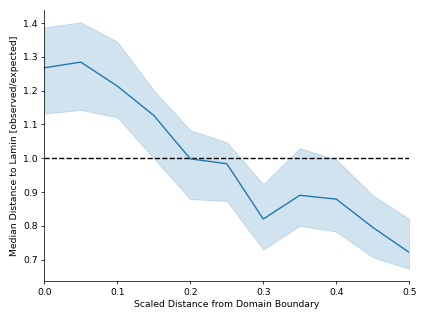

In [22]:
fig, ax = make_oe_lamin_plot(oe, estimator=np.median)

plt.tight_layout()

plt.savefig("./panel_g_profile/observed_profile.svg")